# Deeplearning - Anees Ahmad - 2021/08/08

# 9 Advanced deep learning for computer vision

## 9.3 Modern convnet architecture patterns

- A model’s “architecture” is the sum of the choices that went into creating it: 
  - which layers to use, how to configure them, and in what arrangement to connect them
- hypothesis space of your model: 
  - the space of possible functions that gradient descent can search over, parameterized by the model’s weights
  - good hypothesis space encodes prior knowledge that you have about the problem at hand and its solution
- A good model architecture is one that reduces the size of the search space or otherwise makes it easier to converge to a good point of the search space

### 9.3.1 Modularity, hierarchy, and reuse

- make a complex system simpler
  - just structure your amorphous soup of complexity into modules
  - organize the modules into a hierarchy
  - start reusing the same modules in multiple places as appropriate
- a deep stack of narrow layers performs better than a shallow stack of large layers.

##### On the importance of ablation studies in deep learning research

- Deep learning architectures are often more evolved than designed
- ablation studies
  - it consist of systematically trying to remove parts of a system—making it simpler—to identify where its performance actually comes from.

### 9.3.2 Residual connections

- sequential deep learning model

  ```
  y = f4(f3(f2(f1(x))))
  ```
  - you may lose information due to noise
  - vanishing gradients problem
    - when model is too deep due to noise might be possible back-propagation might not work
  - fix
    - just force each function in the chain to be nondestructive—to retain a noiseless version of the information contained in the previous input. The easiest way to implement this is to use a residual connection
  - A residual connection in pseudocode

    ```
    x = ...
    residual = x
    x = block(x)
    x = add([x, residual])
    ```
    - output and input should have same shape
    - for conv2D use 1*1 conv2D
    - for maxpoling use stride

In [3]:
# Listing 9.2 Residual block where the number of filters changes
from tensorflow import keras 
from tensorflow.keras import layers
 
inputs = keras.Input(shape=(32, 32, 3))
x = layers.Conv2D(32, 3, activation="relu")(inputs)
residual = x
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
residual = layers.Conv2D(64, 1)(residual)
x = layers.add([x, residual]) 

In [4]:
# Listing 9.3 Case where the target block includes a max pooling layer

inputs = keras.Input(shape=(32, 32, 3))
x = layers.Conv2D(32, 3, activation="relu")(inputs)
residual = x
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
x = layers.MaxPooling2D(2, padding="same")(x)
residual = layers.Conv2D(64, 1, strides=2)(residual)
x = layers.add([x, residual])

In [5]:
# a simple convnet structured into a series of blocks, 
# each made of two convolution layers and one optional max pooling layer, 
# with a residual connection around each block

inputs = keras.Input(shape=(32, 32, 3))
x = layers.Rescaling(1./255)(inputs)
 
def residual_block(x, filters, pooling=False):
  residual = x
  x = layers.Conv2D(filters, 3, activation="relu", padding="same")(x)
  x = layers.Conv2D(filters, 3, activation="relu", padding="same")(x)
  if pooling:
    x = layers.MaxPooling2D(2, padding="same")(x)
    residual = layers.Conv2D(filters, 1, strides=2)(residual)
  elif filters != residual.shape[-1]:
    residual = layers.Conv2D(filters, 1)(residual)
  x = layers.add([x, residual])
  return x

x = residual_block(x, filters=32, pooling=True)
x = residual_block(x, filters=64, pooling=True)
x = residual_block(x, filters=128, pooling=False)
x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 rescaling (Rescaling)          (None, 32, 32, 3)    0           ['input_3[0][0]']                
                                                                                                  
 conv2d_6 (Conv2D)              (None, 32, 32, 32)   896         ['rescaling[0][0]']              
                                                                                                  
 conv2d_7 (Conv2D)              (None, 32, 32, 32)   9248        ['conv2d_6[0][0]']               
                                                                                              

### 9.3.3 Batch normalization

- Normalization
  - methods that seek to make different samples seen by a machine learning model more similar to each other, which helps the model learn and generalize well to new data.
  - common form of data normalization
    - centering the data on zero by subtracting the mean from the data, and giving the data a unit standard deviation by dividing the data by its standard deviation

      ```
      normalized_data = (data - np.mean(data, axis=...)) / np.std(data, axis=...)
      ```

- Batch normalization
  - a type of layer ( BatchNormalization in Keras)
  - it can adaptively normalize data even as the mean and variance change over time during training. 
    - During training, it uses the mean and variance of the current batch of data to normalize samples
    - during inference, it uses an exponential moving average of the batch-wise mean and variance of the data seen during training
  - main effect of batch normalization appears to be that it helps with gradient propagation
  - The BatchNormalization layer can be used after any layer— Dense , Conv2D

In [ ]:
# Listing 9.4 How not to use batch normalization
x = layers.Conv2D(32, 3, activation="relu")(x)
x = layers.BatchNormalization()(x)

In [ ]:
# Listing 9.5 How to use batch normalization: the activation comes last
x = layers.Conv2D(32, 3, use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x) 

### 9.3.4 Depthwise separable convolutions

- depthwise separable convolution layer
  - drop-in replacement for Conv2D
  - make model 
    - smaller
    - leaner
    - cause it to perform a few percentage points better on its task
  - This layer performs a spatial convolution on each channel of its input independently, before mixing output channels via a pointwise convolution
  - equivalent to separating the learning of spatial features and the learning of channel-wise features.
  - assumes that spatial locations in intermediate activations are highly correlated, but different channels are highly independent

- Depthwise separable convolution 
  - requires significantly fewer parameters, involves fewer computations compared to regular convolution, while having comparable representational power. 
  - It results in smaller models that converge faster and are less prone to overfitting

##### The co-evolution of hardware, software, and algorithms

-  depthwise separable convolutions remains a good idea even if it does not result in a speedup: 
  - their lower parameter count means that you are less at risk of overfitting
  - their assumption that channels should be uncorrelated leads to faster model convergence and more robust representations.


### 9.3.5 Putting it together: A mini Xception-like model

- convnet architecture principles
  - Your model should be organized into repeated blocks of layers, usually made of multiple convolution layers and a max pooling layer.
  - The number of filters in your layers should increase as the size of the spatial feature maps decreases.
  - Deep and narrow is better than broad and shallow.
  - Introducing residual connections around blocks of layers helps you train deeper networks.
  - It can be beneficial to introduce batch normalization layers after your convolution layers.
  - It can be beneficial to replace Conv2D layers with SeparableConv2D layers, which are more parameter-efficient.

##### Cats vs Dogs CNN (architecture principles)

In [1]:
# piece of code to download kaggle data directly to colab
# upload kaggle json file on the colab
from google.colab import files
files.upload()
# make kaggle directory
!mkdir ~/.kaggle
# move kaggle file to newly created folder
!cp kaggle.json ~/.kaggle/
# chnage permissions for file created
!chmod 600 ~/.kaggle/kaggle.json
# Downlaod data from kaggle
!kaggle competitions download -c dogs-vs-cats

Saving kaggle.json to kaggle.json
 97% 786M/812M [00:04<00:00, 200MB/s]
100% 812M/812M [00:04<00:00, 199MB/s]


In [2]:
# unzip downloaded data
!unzip -qq dogs-vs-cats.zip
!unzip -qq train.zip

In [3]:
# Copying images to training, validation, and test directories

# imports
import os, shutil, pathlib

# path to complete data set 
original_dir = pathlib.Path("train")
# path to smaller data set
new_base_dir = pathlib.Path("cats_vs_dogs_small")

# function to get images from complete set and save in subset
def make_subset(subset_name, start_index, end_index):
  # loop over cat and dog category
  for category in ("cat", "dog"):
    # path to new directory
    dir = new_base_dir / subset_name / category
    # make new directories
    os.makedirs(dir)
    # range of files names
    fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
    for fname in fnames:
      # copy files from source to target
      shutil.copyfile(src=original_dir / fname, dst=dir / fname)
 
# call sfor train, validation and test set
make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

In [4]:
#  Using image_dataset_from_directory to read images
  # image_dataset_from_directory(directory) will list the subdirectories of directory
  # index the image files in each subdirectory
  # create and return a tf.data.Dataset object 
    # configured to read these files, 
    # shuffle them
    # decode them to tensors
    # resize them to a shared size
    # and pack them into batches.

from tensorflow.keras.utils import image_dataset_from_directory
 
# create datasets
train_dataset = image_dataset_from_directory(
    # path of the directory
    new_base_dir / "train",
    # reshape images to said size
    image_size=(180, 180),
    # batch size / 32 samples per batch
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [5]:
# Displaying the shapes of the data and labels yielded by the Dataset
for i, element in enumerate(train_dataset):
  pass
print("bathces of train_dataset : ",i)

for train_data_batch, train_labels_batch in train_dataset:
  print("train data batch shape:", train_data_batch.shape)
  print("train labels batch shape:", train_labels_batch.shape)
  break

for i, element in enumerate(validation_dataset):
  pass
print("bathces of validation_dataset : ",i)
for validation_data_batch, validation_labels_batch in validation_dataset:
  print("validation data batch shape:", validation_data_batch.shape)
  print("validation labels batch shape:", validation_labels_batch.shape)
  break

for i, element in enumerate(test_dataset):
  pass
print("bathces of test_dataset : ",i)
for test_data_batch, test_labels_batch in test_dataset:
  print("test data batch shape:", test_data_batch.shape)
  print("test labels batch shape:", test_labels_batch.shape)
  break

bathces of train_dataset :  62
train data batch shape: (32, 180, 180, 3)
train labels batch shape: (32,)
bathces of validation_dataset :  31
validation data batch shape: (32, 180, 180, 3)
validation labels batch shape: (32,)
bathces of test_dataset :  62
test data batch shape: (32, 180, 180, 3)
test labels batch shape: (32,)


In [8]:
# Define a data augmentation stage to add to an image mode
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential(
    [
     layers.RandomFlip("horizontal"),
     layers.RandomRotation(0.1),
     layers.RandomZoom(0.2),
    ]
  )

In [9]:
# Model

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=5, use_bias=False)(x)

for size in [32, 64, 128, 256, 512]:
  residual = x
  x = layers.BatchNormalization()(x)
  x = layers.Activation("relu")(x)
  x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation("relu")(x)
  x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)
  x = layers.MaxPooling2D(3, strides=2, padding="same")(x)
  residual = layers.Conv2D(size, 1, strides=2, padding="same", use_bias=False)(residual)
  x = layers.add([x, residual])

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [10]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 180, 180, 3)  0           ['input_1[0][0]']                
                                                                                                  
 rescaling (Rescaling)          (None, 180, 180, 3)  0           ['sequential[0][0]']             
                                                                                                  
 conv2d (Conv2D)                (None, 176, 176, 32  2400        ['rescaling[0][0]']          

In [11]:
model.compile(
    loss="binary_crossentropy",
    optimizer="rmsprop",
    metrics=["accuracy"])

In [12]:
# Training the regularized convnet
callbacks = [
  keras.callbacks.ModelCheckpoint(
  filepath="cats_vs_dogs_small_with_architecture_principles.keras",
  save_best_only=True,
  monitor="val_loss")
]
history = model.fit(
  train_dataset,
  epochs=100,
  validation_data=validation_dataset,
  callbacks=callbacks)

Epoch 1/100
63/63 [==============================] - 43s 422ms/step - loss: 0.7076 - accuracy: 0.5645 - val_loss: 0.6989 - val_accuracy: 0.5000
Epoch 2/100
63/63 [==============================] - 26s 411ms/step - loss: 0.6536 - accuracy: 0.6145 - val_loss: 0.6991 - val_accuracy: 0.5010
Epoch 3/100
63/63 [==============================] - 26s 408ms/step - loss: 0.6488 - accuracy: 0.6220 - val_loss: 0.6999 - val_accuracy: 0.5000
Epoch 4/100
63/63 [==============================] - 26s 408ms/step - loss: 0.6295 - accuracy: 0.6445 - val_loss: 0.6963 - val_accuracy: 0.5000
Epoch 5/100
63/63 [==============================] - 26s 412ms/step - loss: 0.6150 - accuracy: 0.6545 - val_loss: 0.7038 - val_accuracy: 0.5000
Epoch 6/100
63/63 [==============================] - 26s 415ms/step - loss: 0.5897 - accuracy: 0.6905 - val_loss: 0.8558 - val_accuracy: 0.5000
Epoch 7/100
63/63 [==============================] - 26s 412ms/step - loss: 0.5744 - accuracy: 0.6985 - val_loss: 0.7555 - val_accuracy:

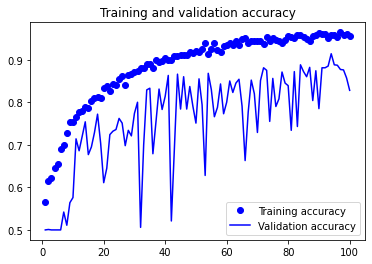

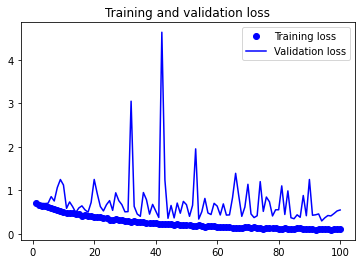

In [13]:
# Displaying curves of loss and accuracy during training
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [14]:
# Evaluating the model on the test set
test_model = keras.models.load_model("cats_vs_dogs_small_with_architecture_principles.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 3s 41ms/step - loss: 0.3739 - accuracy: 0.8975
Test accuracy: 0.897


---